In [21]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
save_dir = '20240611/S-体系-all metrics/ROC_Curves_FE CO'
os.makedirs(save_dir, exist_ok=True)

In [22]:
# 读取数据
csv_path = 'S-体系-逐步回归挑选出来的特征/selected_features-CO.csv'
dataset = pd.read_csv(csv_path)
print(dataset.head())

   Conju-Strut Wiener Index (Max-Conju)  NumAromaticRings  \
0                              1.023810                 1   
1                              0.866667                 1   
2                              0.666667                 0   
3                              0.666667                 0   
4                              0.500000                 0   

   Fun_PEOE-Charge_Mean  Full-Mol Wiener Index  Conju_PEOE-Charge_Max  \
0          1.241938e-01               1.427273          -1.259678e-01   
1         -2.780000e-17               0.866667          -4.160000e-17   
2         -9.395815e-02               0.900000          -1.231819e-01   
3         -1.515180e-01               2.030303          -1.337200e-01   
4         -1.928926e-02               1.333333          -1.928926e-02   

   Mid-Fun_LogP_Delta     Chi2v  PEOE_VSA9  Atom_MR_Max  Occupied Orbitals  \
0              0.3808  3.247225   4.877147        6.691                 44   
1              0.0000  3.244094   3.78

In [23]:
import sys
# 读取数据
csv_path2 = 'Target.csv'
dataset2 = pd.read_csv(csv_path2)
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
dataset.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in dataset.columns.values]
labels = dataset2['FEaverage CO']
features = dataset
X = features
y = labels

# 标准化特征数据
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)
print(y)

[[ 0.19235777  0.11111111  1.93970428 ... -0.44236109 -0.11111111
  -0.30381311]
 [-0.04693731  0.11111111  0.52927935 ... -0.44236109 -0.11111111
  -0.53688635]
 [-0.35149468 -1.02777778 -0.53777044 ... -0.44236109 -0.11111111
   0.56884946]
 ...
 [-1.36668593 -1.02777778 -0.34701047 ... -0.44236109 -0.11111111
   0.22598797]
 [-1.36668593 -1.02777778 -0.3470046  ... -0.44236109 -0.11111111
   0.28723815]
 [-1.36668593 -1.02777778 -0.33699838 ... -0.44236109 -0.11111111
   0.63036315]]
0     14.760128
1     18.144924
2     20.750142
3     19.887920
4     21.001702
        ...    
77     6.013192
78     3.219462
79     2.026439
80    18.885723
81     8.596870
Name: FEaverage CO, Length: 82, dtype: float64


In [24]:

# 二值化目标变量
threshold = y.median()
y_binary = np.where(y > threshold, 1, 0)
y=y_binary
# 划分初始训练集、验证集和测试集
X_train_val, X_test1, y_train_val, y_test1 = train_test_split(X, y_binary, test_size=0.1, random_state=42)

# 定义模型和超参数空间
param_spaces = {
    'LR': {
        'model': LogisticRegression(max_iter=5000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']     
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [1e-2, 1e-1, 1, 10, 100],
            'gamma': [1e-3, 1e-2, 1e-1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf']
        }
    },
    'RF': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [5, 10, 20, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=5000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
            'learning_rate': ['constant', 'adaptive']
        }
    },
    'DT': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 40, 50],
            'p': [1, 2]
        }
    }
}



In [25]:

# 初始化变量存储最佳模型和参数
best_models = {}
# 10折交叉验证
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# 进行超参数调优和模型训练
for model_name, model_info in param_spaces.items():
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        verbose=2,
        return_train_score=True
    )

    grid_search.fit(X_train_val, y_train_val)
    best_models[model_name] = grid_search.best_estimator_
    print(f"最佳 {model_name} 参数: {grid_search.best_params_}")
    print(f"最佳 {model_name} 得分: {grid_search.best_score_}")
# 检查每个模型的最佳参数是否已保存
for model_name in ['LR', 'RF', 'SVM', 'MLP']:
    if model_name not in best_models:
        raise KeyError(f"未找到 {model_name} 模型的最佳参数")

#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #训练集（占85%），测试集15

# 初始化分类器
classifiers = {
    'DT': DecisionTreeClassifier(**best_models['DT'].get_params()),
    'KNN': KNeighborsClassifier(**best_models['KNN'].get_params()),
    'LR': LogisticRegression(**best_models['LR'].get_params()),
    'RF': RandomForestClassifier(**best_models['RF'].get_params()),
    'SVM': SVC(**best_models['SVM'].get_params()),
    'MLP': MLPClassifier(**best_models['MLP'].get_params())
}


abbreviations = ['DT', 'KNN', 'LR', 'RF', 'SVM', 'MLP']  # 包含分类器名称缩写的列表



Fitting 10 folds for each of 24 candidates, totalling 240 fits
最佳 LR 参数: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
最佳 LR 得分: 0.7267857142857144
Fitting 10 folds for each of 75 candidates, totalling 750 fits
最佳 SVM 参数: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
最佳 SVM 得分: 0.7428571428571428
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   3.9s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total t

[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   1.3s[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.8s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   2.5s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.0s
[CV] END 

[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.4s[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   4.1s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.01, gamma=10, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END

[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   3.5s
[CV] END ...................

[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  11.0s最佳 RF 参数: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
最佳 RF 得分: 0.7857142857142858
Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=  11.4s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear;

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   6.5s[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   6.1s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=10, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total ti

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.2s[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   4.4s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total t

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  19.9s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total ti

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.3s[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   2.9s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   3.7s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   4.3s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.6s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   3.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; tot

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  23.9s[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.7s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   4.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total 

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  27.0s[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.8s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   8.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=10, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total 

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   3.8s[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   4.2s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; tot

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   5.2s[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   4.7s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; tot

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  17.5s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total ti

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.1s[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   5.6s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=10, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; tota

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.3s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.3s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; tota

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.6s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   4.8s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; tota

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.7s[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.8s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   3.1s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.2s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; tota

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   5.5s[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   4.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=10, kernel=rbf; to

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  12.8s[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   4.7s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total tim

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  43.8s[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.9s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   3.4s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; tot

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   6.3s[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.1s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   3.0s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total ti

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   3.6s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   4.1s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  30.4s[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.1s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   3.3s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total 

[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   3.9s
[CV] END .................C=0.01, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.01, gamma=10, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   5.7s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total tim

[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.3s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.2s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   5.6s
[CV] END ....................C=0.01, gamma=0.001, kernel=rbf; total

[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   9.9s[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.6s
[CV] END ......................C=10, penalty=l1, solver=saga; tot

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.3s最佳 MLP 参数: {'activation': 'relu', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
最佳 MLP 得分: 0.7285714285714285
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.4s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   3.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END ....................C=0.01, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ....

[CV] END criterion=gini, max_depth=40, min_samples_leaf=2, min_samples_split=5; total time=   0.0s[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=10, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..

[CV] END criterion=gini, max_depth=50, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   1.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.7s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   4.4s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   4.0s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=  

[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.0s[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   5.8s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  19.0s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.4s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  38.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.2s
[CV] END activation=tanh, alpha=0.0001, hi

[CV] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  11.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  16.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  25.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   4.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  12.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.2s
[CV] END activation=tanh, alpha=0.01, hidden_l

[CV] END criterion=entropy, max_depth=30, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  22.1s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=sgd; total time=  31.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  22.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  28.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   5.7s
[CV] END activation=tanh, alp

[CV] END criterion=entropy, max_depth=40, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  10.9s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  13.2s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.8s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  22.5s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=sgd; total time=  38.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes

[CV] END criterion=entropy, max_depth=50, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  41.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   5.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  28.2s
[CV] END activation=tanh, alpha=0.0

Fitting 10 folds for each of 400 candidates, totalling 4000 fits

[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   7.0s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.3s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  28.2s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=sgd; total time=  42.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  18.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  31.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   6.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), lear

[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  18.5s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  19.7s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  34.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   5.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  16.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   7.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   7.5s
[CV] END activation=tanh, alpha=0.0001, hidden_lay

[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   5.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  14.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  13.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  19.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  39.0s
[CV] END activation=tanh, alpha=0.001, 

[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=sgd; total time=  43.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  19.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  44.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   5.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  14.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  20.3s
[CV] END activation=tanh, alpha=0.001, hid

[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  37.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  13.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   2.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  19.4s
[CV] END activation=tanh, alpha=0.001, hidden_l

[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  13.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  13.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   5.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   5.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  22.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   4.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=sgd; total time=  31.4s
[CV] END activation=tanh, alpha=0.01, hidden_la

[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  37.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  14.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  23.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  10.8s
[CV] END activation=relu, alpha=1e-05, hidden_layer

[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   5.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  17.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  20.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  28.3s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  11.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_siz

[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  20.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  17.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   5.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  37.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_

[CV] END algorithm=auto, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  23.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=sgd; total time=  40.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  13.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  26.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  15.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  15.6s
[CV] END activation=tanh, alpha=0.01, hidden_l

[CV] END algorithm=auto, leaf_size=30, n_neighbors=7, p=2, weights=uniform; total time=   0.0s[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  13.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  13.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  21.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=   4.5s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  10.4s
[CV] END activation=relu, alpha=1e-05, hidden_lay

[CV] END algorithm=auto, leaf_size=30, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  12.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  11.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  22.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=sgd; total time=  50.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time= 1.1min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   7.9s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time=  54.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   9.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=adam; total time=   8.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  24.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  13.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   7.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate=constant, solver=sgd; total time= 1.1min
[CV] END activation=relu, alpha=

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  31.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive, solver=adam; total time=  11.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=20, min_samples_

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=10; tot

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=2, weights=distance; total time=   0.0

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END criterion=gini, max_depth=40, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10; t

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=40, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance; total time=   

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, 

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=2

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20,

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, 

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20

[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_

[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.0

[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_n

[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n

[CV] END algorithm=brute, leaf_size=10, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_ne

[CV] END algorithm=brute, leaf_size=10, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=50, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=50, n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, leaf_size=50, n_nei


[CV] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=50, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=50, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=50, n_ne

[CV] END algorithm=brute, leaf_size=20, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.2s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.1s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.2s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s


[CV] END algorithm=brute, leaf_size=50, n_neighbors=7, p=1, weights=distance; total time=   0.0s最佳 KNN 参数: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
最佳 KNN 得分: 0.775


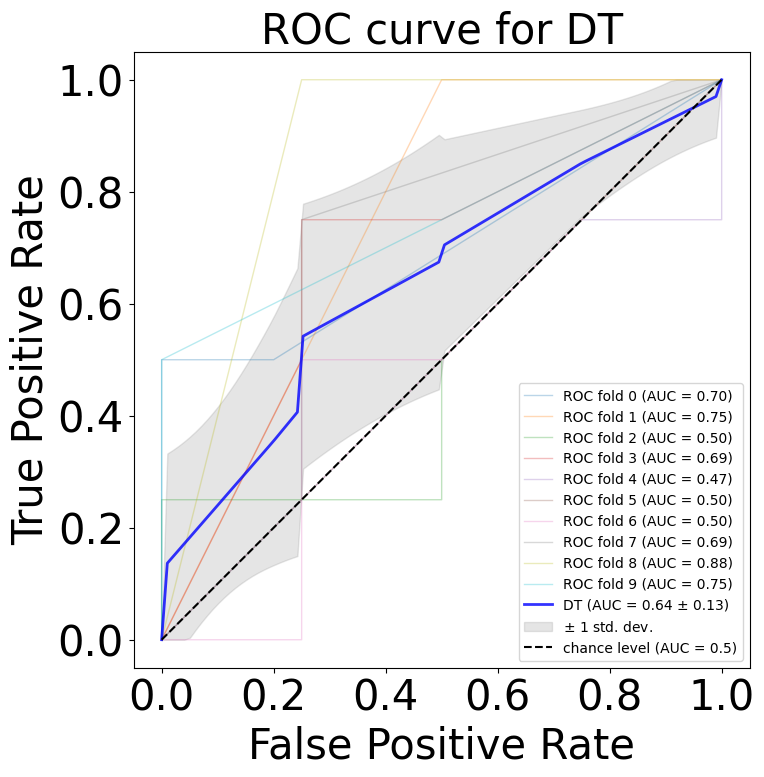

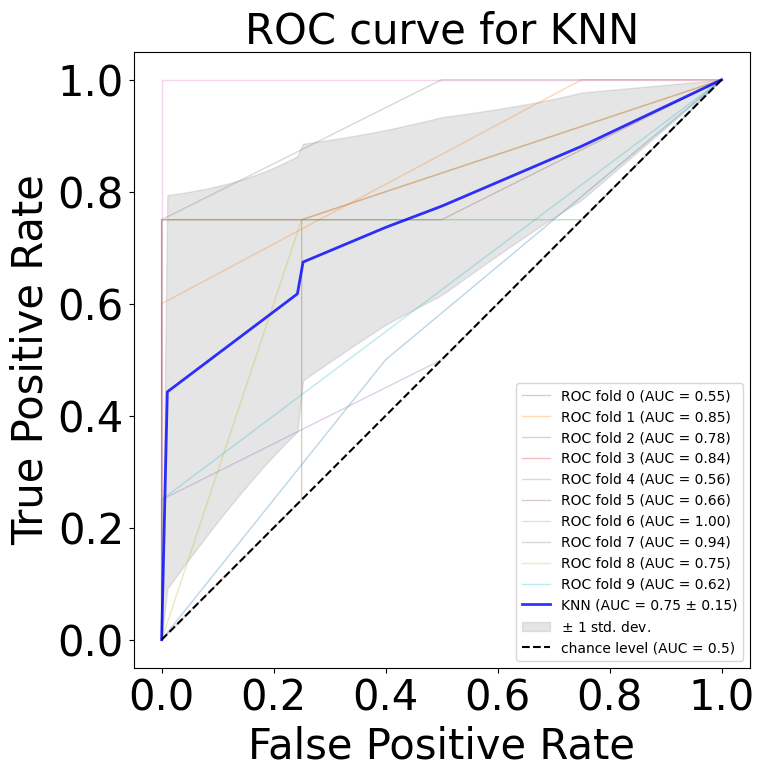

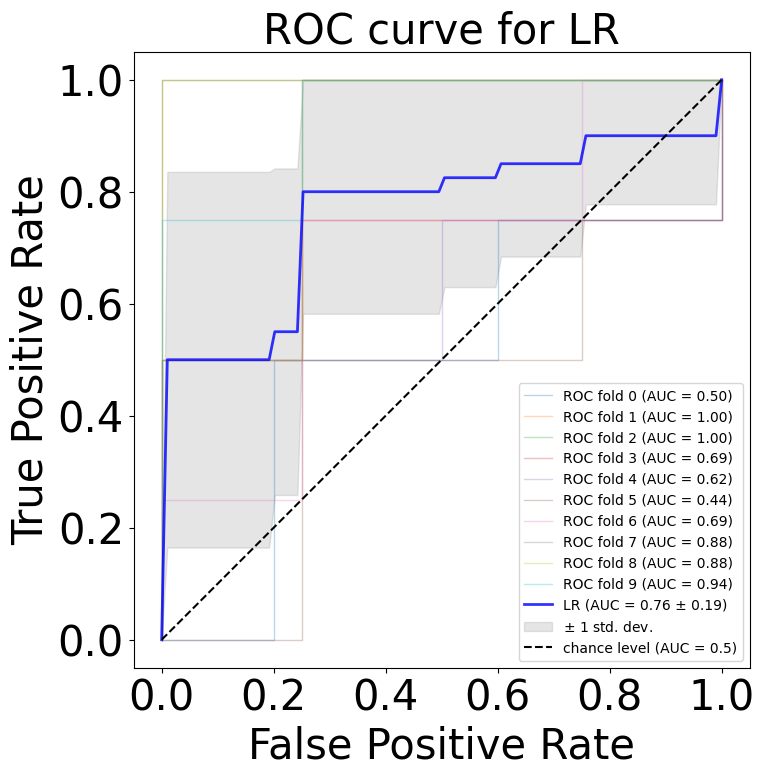

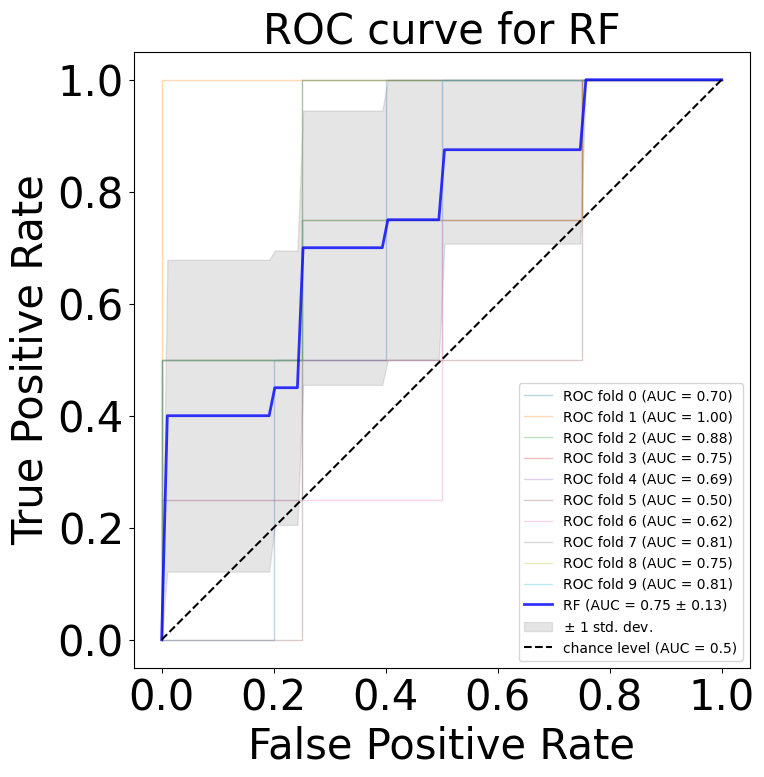

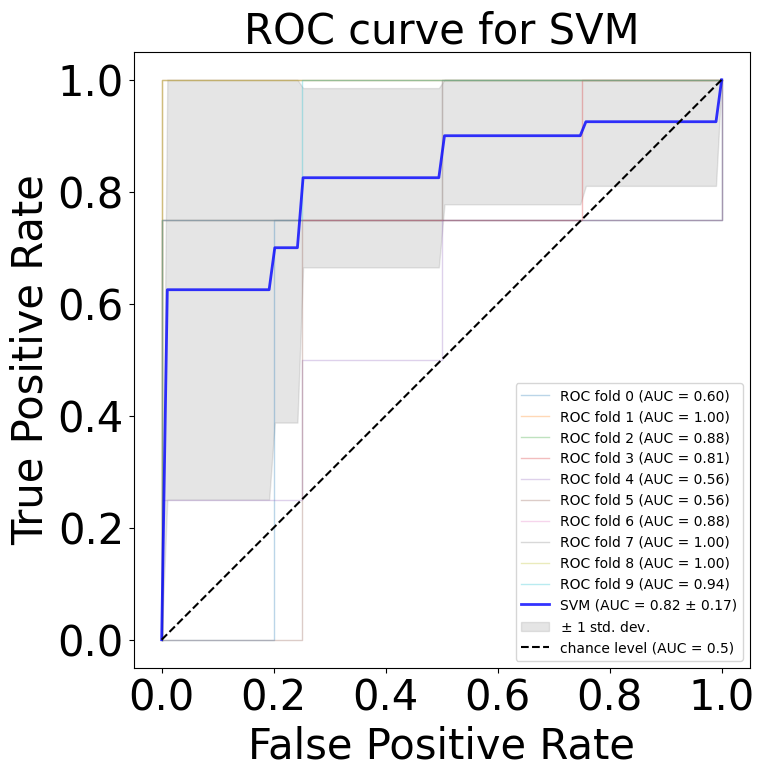


[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorith


[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size


[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algo


[CV] END algorithm=brute, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

/home/jyb/.conda/envs/cyt/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END al

[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=brute, leaf_siz


[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=b


[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance; total time=   


[CV] END algorithm=brute, leaf_size=20, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_si


[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algo

/home/jyb/.conda/envs/cyt/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algo

/home/jyb/.conda/envs/cyt/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jyb/.conda/envs/cyt/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algo

/home/jyb/.conda/envs/cyt/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



[CV] END algorithm=brute, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.1s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_

/home/jyb/.conda/envs/cyt/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=50, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algor

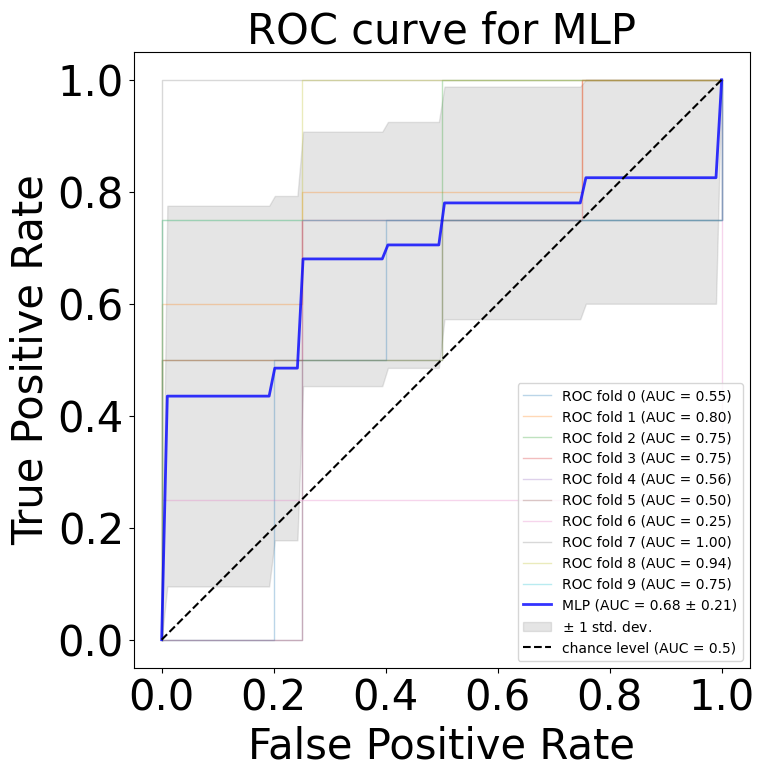

In [26]:
# Plot ROC curves for each classifier
metrics_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for abbr, classifier in zip(abbreviations, classifiers.values()):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100) #定义了一个从0到1的100个点的等间隔数组，用于插值。
    cv = StratifiedKFold(n_splits=10) #定义了一个x折的分层交叉验证策略

    fig, ax = plt.subplots(figsize=(8, 8)) #8x8英寸的图形和轴，用于绘制ROC曲线
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        y_pred_proba = classifier.predict_proba(X[test])[:, 1]
        viz = RocCurveDisplay.from_predictions(
            y[test],
            y_pred_proba,
            name=f"ROC fold {i}",
            lw=1,#线条宽度
            alpha=0.3,#线条透明度
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"{abbr} (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
        lw=2,
        alpha=0.8,
        color='blue',
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"ROC curve for {abbr}",
    )
    ax.set_xticks(np.arange(0, 1.2, 0.2))  # 设置横坐标数值的间隔为0.2
    ax.set_yticks(np.arange(0, 1.2, 0.2))  # 设置纵坐标数值的间隔为0.2     
    ax.set_xlabel("False Positive Rate", fontsize=30)
    ax.set_ylabel("True Positive Rate", fontsize=30)
    ax.set_title(f"ROC curve for {abbr}", fontsize=30)
    ax.axis("square")
    ax.tick_params(axis='both', which='major', labelsize=30)  # 设置横纵坐标数值字体大小
    ax.legend(loc="lower right", fontsize=10)
    save_path1 = os.path.join(save_dir, f'{abbr}_ROC.png')
    plt.savefig(save_path1, bbox_inches='tight', dpi=600)
    plt.show()

In [27]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# 读取数据
#csv_path = 'result/selected_features-H2.csv'
dataset = pd.read_csv(csv_path)
print(dataset.head())

# 读取数据
#csv_path2 = 'Target.csv'
dataset2 = pd.read_csv(csv_path2)
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
dataset.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in dataset.columns.values]
#labels = dataset2['FEaverage H2']
features = dataset
X = features
y = labels

# 标准化特征数据
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)
print(y)
threshold = y.median()
y_binary = np.where(y > threshold, 1, 0)
y=y_binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 初始化分类器
DT= DecisionTreeClassifier(**best_models['DT'].get_params())
KNN= KNeighborsClassifier(**best_models['KNN'].get_params())
LR=LogisticRegression(**best_models['LR'].get_params())
RF=RandomForestClassifier(**best_models['RF'].get_params())
SVM=SVC(**best_models['SVM'].get_params())
MLP=MLPClassifier(**best_models['MLP'].get_params())
classifiers=[DT, KNN, LR, RF, SVM, MLP]
abbreviations = ['DT', 'KNN', 'LR', 'RF', 'SVM', 'MLP']  # 包含分类器名称缩写的列表

#  初始化混淆矩阵
overall_cm = {abbr: np.zeros((2, 2), dtype=float) for abbr in abbreviations}
# 初始化列表以存储每个分类器的度量值
results = []
# Lists to store average metrics for each classifier
avg_accuracies = []
avg_precisions = []
avg_recalls = []
avg_f1_scores = []
# Perform 10-fold cross-validation and calculate metrics
cv = StratifiedKFold(n_splits=10)

for classifier, abbr in zip(classifiers, abbreviations):
    # Lists to store metric values for each fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for fold, (train_index, test_index) in enumerate(cv.split(X, y), 1):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        classifier.fit(X_train_fold, y_train_fold)
        y_pred = classifier.predict(X_test_fold)

        # Calculate metrics for each fold
        accuracy = accuracy_score(y_test_fold, y_pred)
        precision = precision_score(y_test_fold, y_pred, zero_division=1)
        recall = recall_score(y_test_fold, y_pred, zero_division=1)
        f1 = f1_score(y_test_fold, y_pred, zero_division=1)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Store metrics for this fold
        results.append({
            'Classifier': abbr,
            'Fold': fold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        # Accumulate confusion matrix for each fold
        cm = confusion_matrix(y_test_fold, y_pred)
        overall_cm[abbr] += cm

    # Calculate mean metrics for all folds
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    # Store average metrics for this classifier
    avg_accuracies.append(avg_accuracy)
    avg_precisions.append(avg_precision)
    avg_recalls.append(avg_recall)
    avg_f1_scores.append(avg_f1)
    # Store average metrics in results
    results.append({
        'Classifier': abbr,
        'Fold': 'Average',
        'Accuracy': avg_accuracy,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1 Score': avg_f1
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)
save_path2 = os.path.join(save_dir,'metrics.csv')
# Write results to an Excel file
df_results.to_csv(save_path2, index=False)
print("Results saved to 'metrics.csv'")
# Print average metrics for all classifiers
for i, abbr in enumerate(abbreviations):
    print(f"Metrics for {abbr}:")
    print(f"Average Accuracy: {avg_accuracies[i]:.2f}")
    print(f"Average Precision: {avg_precisions[i]:.2f}")
    print(f"Average Recall: {avg_recalls[i]:.2f}")
    print(f"Average F1 Score: {avg_f1_scores[i]:.2f}")
    print()



   Conju-Strut Wiener Index (Max-Conju)  NumAromaticRings  \
0                              1.023810                 1   
1                              0.866667                 1   
2                              0.666667                 0   
3                              0.666667                 0   
4                              0.500000                 0   

   Fun_PEOE-Charge_Mean  Full-Mol Wiener Index  Conju_PEOE-Charge_Max  \
0          1.241938e-01               1.427273          -1.259678e-01   
1         -2.780000e-17               0.866667          -4.160000e-17   
2         -9.395815e-02               0.900000          -1.231819e-01   
3         -1.515180e-01               2.030303          -1.337200e-01   
4         -1.928926e-02               1.333333          -1.928926e-02   

   Mid-Fun_LogP_Delta     Chi2v  PEOE_VSA9  Atom_MR_Max  Occupied Orbitals  \
0              0.3808  3.247225   4.877147        6.691                 44   
1              0.0000  3.244094   3.78

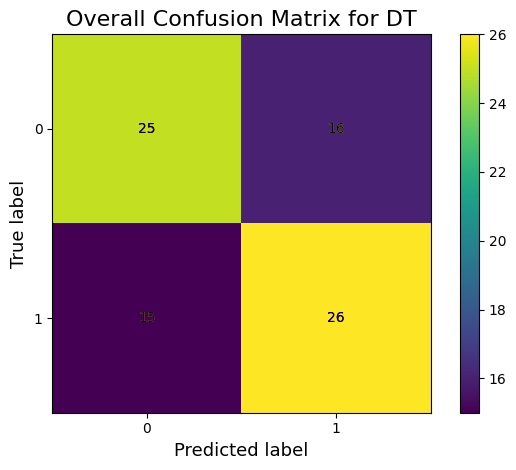

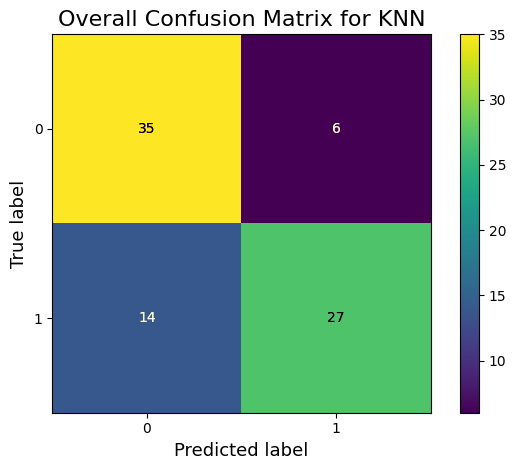

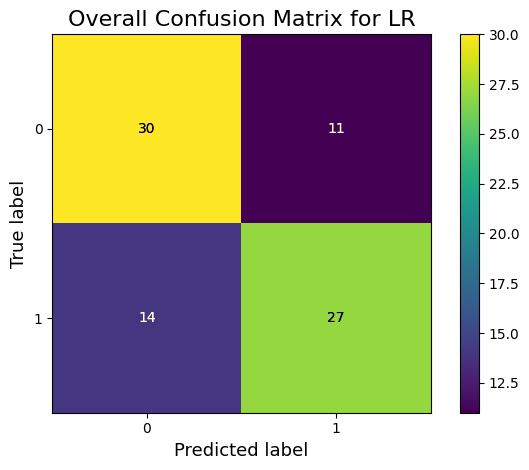

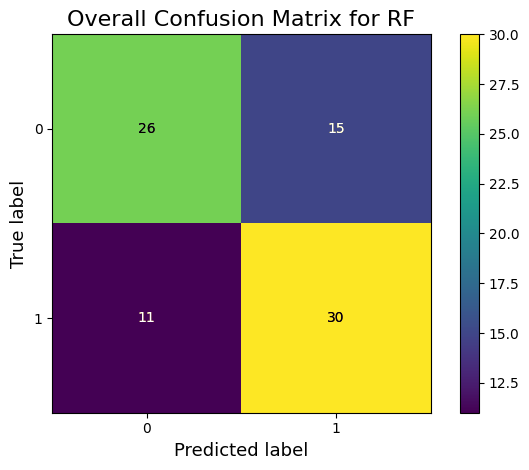

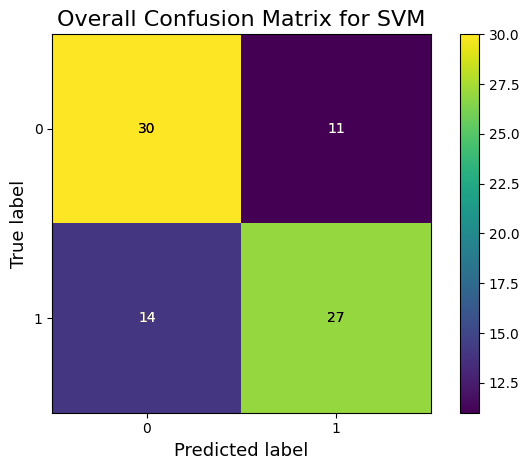

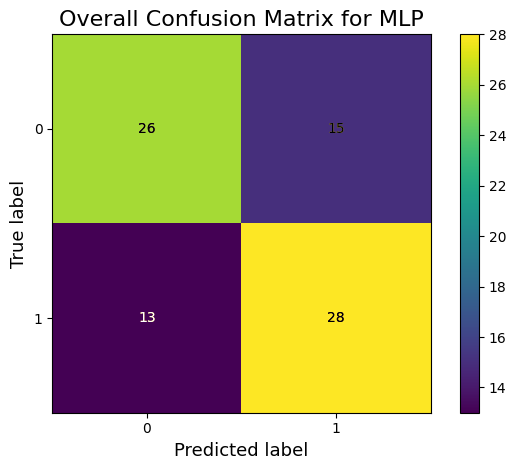

In [28]:
'''混淆矩阵'''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
save_dir2 = '20240611/S-体系-all metrics/Confusion matrixs_FE CO'
os.makedirs(save_dir2, exist_ok=True)

# Plot and save the average confusion matrix
for abbr, cm in overall_cm.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int))
    disp.plot(cmap='viridis')  # 使用默认的 'viridis' 颜色图

    plt.title(f'Overall Confusion Matrix for {abbr}', fontsize=16)
    plt.xlabel('Predicted label', fontsize=13)
    plt.ylabel('True label', fontsize=13)
    plt.xticks([0, 1], ['0', '1'])
    plt.yticks([0, 1], ['0', '1'])

    # 标注具体数值
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{int(cm[i, j])}',
                     ha="center", va="center",
                     color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir2, f'{abbr}_overall_confusion_matrix.png'), bbox_inches='tight', dpi=600)
    plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

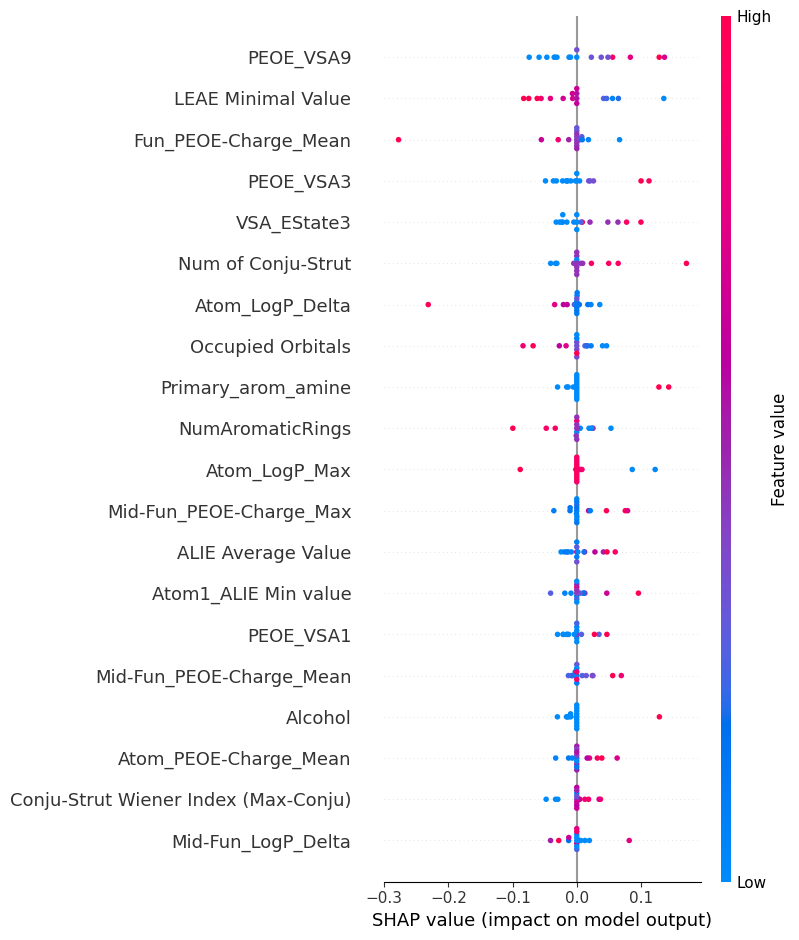

In [30]:
#SHAP analysis
import shap
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 创建保存SHAP图的文件夹
shap_save_dir = '20240611/S-体系-all metrics/shap_results-CO'
os.makedirs(shap_save_dir, exist_ok=True)

# 由于分类器太多封装SHAP分析方法
def perform_shap_analysis(model, model_name):
    model.fit(X_train, y_train)  # 确保模型已拟合
    if model_name in ['DT', 'RF']:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
    else:
        # 使用KernelExplainer进行非树模型的解释
        explainer = shap.KernelExplainer(model.predict_proba, X_train[:100])  # 使用部分训练数据进行初始化
        shap_values = explainer.shap_values(X_test, nsamples=100)

    # 将X_test转换回DataFrame，以便显示特征名称
    X_test_df = pd.DataFrame(X_test, columns=features.columns)
    
    # 获取排名靠前的特征名称
    shap_values_abs = np.abs(shap_values[1])
    feature_importance = np.mean(shap_values_abs, axis=0)
    sorted_idx = np.argsort(feature_importance)[::-1]
    top_features = X_test_df.columns[sorted_idx][:top_n_features]
    
    # 将特征名称写入CSV文件
    csv_save_path = os.path.join(shap_save_dir, f'{model_name}-top-features.csv')
    df_top_features = pd.DataFrame(top_features, columns=['Descriptor of interest'])
    df_top_features.to_csv(csv_save_path, index=False)
    
    # 可视化SHAP值并保存
    summary_plot_path = os.path.join(shap_save_dir, f'{model_name}-shap-summary.png')

    # Summary Plot
    plt.figure()
    shap.summary_plot(shap_values[1], X_test_df, show=False)  # 对于二分类模型，使用类别1的SHAP值
    plt.savefig(summary_plot_path, bbox_inches='tight')
    plt.show()
    
    effect_list = []

    # 输出每个特征的SHAP值和对应的特征值到CSV文件
    for rank, feature in enumerate(top_features):
        feature_idx = X_test_df.columns.get_loc(feature)
        feature_values = X_test_df.iloc[:, feature_idx]
        feature_shap_values = shap_values[1][:, feature_idx]
        feature_df = pd.DataFrame({'Feature Value': feature_values, 'SHAP Value': feature_shap_values})
        
        # 计算特征值与SHAP值之间的相关性系数
        correlation = np.corrcoef(feature_values, feature_shap_values)[0, 1]
        if correlation > 0:
            effect = '+' * (top_n_features - rank)
        elif correlation < 0:
            effect = '-' * (top_n_features - rank)
        else:
            effect = '0'
        
        effect_list.append({'Feature': feature, 'Effect': effect})
        
        sanitized_feature_name = feature.replace("/", "_").replace(" ", "_").replace(":", "_").replace("*", "_")  # 替换特殊字符
        feature_csv_path = os.path.join(shap_save_dir, f'{model_name}-{sanitized_feature_name}-shap-values.csv')
        feature_df.to_csv(feature_csv_path, index=False)
    
    # 将特征效应写入专门的CSV文件
    effect_df = pd.DataFrame(effect_list)
    effect_csv_path = os.path.join(shap_save_dir, f'{model_name}-features-effects.csv')
    effect_df.to_csv(effect_csv_path, index=False)

# 指定要显示的前N个特征
top_n_features = 13

# 调用SHAP分析方法
perform_shap_analysis(MLP, 'MLP')